# Infrared light curve of KIC 8462852
The goal is to compute synthetic IR light curves of the star, assuming that the dimming events are caused by dust that is distributed along a bound, but probably highly eccentric, orbit. Thus, the optical light curve is used as input to calculate the line density of the dust, and with an assumed orbit this dust is turned into IR emission as a function of time.

In [1]:
from multiprocessing import Pool
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from astropy.table import Table
from scipy.interpolate import interp2d,RectBivariateSpline
%matplotlib notebook

In [2]:
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('axes', linewidth=1)

In [3]:
def convmf(m_in,e_in):
    """Convert mean to true anomaly.
        
    Copy of bound orbit part of GMKs IDL straight copy of Vallado's 
    C++ routine.
    """

    m = m_in % (2. * np.pi)
    numiter = 50
    small = 0.00000001
    if e_in > small:

        ecc = e_in

#       ;; /* ------------  initial guess ------------- */
        if (((m < 0.0) and (m > -np.pi)) or (m > np.pi)):
            e0 = m - ecc
        else:
            e0 = m + ecc

        ktr = 1
        e1  = e0 + (m - e0 + ecc * np.sin(e0)) / (1.0 - ecc * np.cos(e0))
        while ((abs(e1 - e0) > small) and (ktr <= numiter)):
            ktr += 1
            e0 = e1
            e1 = e0 + (m - e0 + ecc * np.sin(e0)) / (1.0 - ecc * np.cos(e0))

#       ;; /* ---------  find true anomaly  ----------- */
        sinv = (np.sqrt(1.0 - ecc * ecc) * np.sin(e1)) / (1.0-ecc * np.cos(e1))
        cosv = (np.cos(e1) - ecc) / (1.0 - ecc * np.cos(e1))
        nu   = np.arctan2( sinv, cosv)
            
    else:
#       ;; /* --------------------- circular --------------------- */
        ktr = 0
        nu  = m
        e0  = m

    if nu > np.pi:
            nu -= 2.*np.pi
            
    return nu

def convfm(f_in,ecc):
    """and back the other way."""
    tf2 = np.tan(0.5*f_in)
    fact = np.sqrt( (1.0+ecc)/(1.0-ecc) )
    bige = 2.0*np.arctan2(tf2,fact)
    bigm = bige - ecc*np.sin(bige)
    if bigm > np.pi:
        bigm -= 2*np.pi
    return bigm

def bnu(wav,t):
    """Planck function."""
    k1 = 3.9728949e19
    k2 = 14387.69
    fact1 = k1/(wav**3)
    fact2 = k2/(wav*t)
    return fact1/(np.exp(fact2)-1.0)

In [4]:
# some constants
secperday = 86400.0
mperau = 1.496e11
mstar = 1.43
lstar = 4.68
rstar = 1.58 * 6.957e8 / mperau # in au
dist = 392.

## data
This is the Kepler light curve, which includes the "secular dimming" found by Montet & Simon.

The light curve can be interpolated to 0.1d steps, which saves a bit of space, and is about the lowest we could go without removing useful information (i.e. the shortest event). This still results in problems, since there are ~10^4 points in the light curve and we want to add the emission from all of these sections up, ~10^4 times to produce a light curve.

Thus an approach that allows non-uniform time steps is needed. This methos goes along the light curve and averages any pair of points that differ by less than some given amount, repeating until no more averaging can be done.

In [5]:
# this file has three columns: time, raw flux, normalised flux, and normalised flux with secular dimming.
data = np.genfromtxt('reduced_lc.txt',skip_header=1)

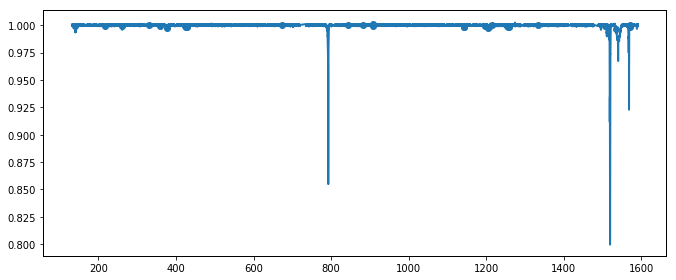

In [6]:
# make a mask to remove some outliers
bad = []
ok = np.ones(len(data[:,0]),dtype=bool)
df = 0.0015
med = np.median(data[:,2])
for i in np.arange(0,len(data[:,2])-2):
    if np.abs(data[i,2]-1) < df and np.abs(data[i+2,2]-1) < df and np.abs(data[i+1,2]-1) > df:
        bad.append(i+1)

ok[bad] = False
data = data[ok]
        
fig,ax = plt.subplots(figsize=(9.5,4))
ax.plot(data[:,0],data[:,2])
ax.scatter(data[bad,0],data[bad,2])
fig.tight_layout()

In [7]:
def reduce_lc(t,f,diff=0.001,dt_min=1.0,
              before=None,before_lev=None,after=None,after_lev=None):
    """Cut down a light curve based on differences between pairs of points."""

    dt = 0.05
    t_tmp = np.arange(np.min(t),np.max(t),dt)
    f_tmp = np.interp(t_tmp,t,f)

    if before is not None:
        xtra = np.min(t_tmp) - np.flipud(np.arange(dt,before,dt))
        t_tmp = np.append(xtra,t_tmp)
        if before_lev is not None:
            bl = before_lev
        else:
            bl = np.median(f_tmp[:5])
        f_tmp = np.append(np.zeros(len(xtra))+bl,f_tmp)

    if after is not None:
        xtra = np.max(t_tmp) + np.arange(dt,after,dt)
        t_tmp = np.append(t_tmp,xtra)
        if after_lev is not None:
            al = after_lev
        else:
            al = np.median(f_tmp[-5:])
        f_tmp = np.append(f_tmp,np.zeros(len(xtra))+al)
    
    old_t = np.array(t_tmp)
    old_f = np.array(f_tmp)
    change = True
#     print(len(old_t))

    while change == True:
        new_t = []
        new_f = []
        for i in np.arange(0,len(old_t)-1,2):
            if np.abs(old_f[i]-old_f[i+1]) < diff and old_t[i+1] - old_t[i] < dt_min:
                new_t.append((old_t[i]+old_t[i+1])/2.)
                new_f.append((old_f[i]+old_f[i+1])/2.)
                change = 1
            else:
                new_t += old_t[i:i+2].tolist()
                new_f += old_f[i:i+2].tolist()

        new_t.append(old_t[-1])
        new_f.append(old_f[-1])

        change = len(old_t) != len(new_t)

        old_t = np.array(new_t)
        old_f = np.array(new_f)

#         print(len(new_t))
        
    print("Light curve reduction:",len(t),"->",len(new_t),"points")
    return np.array(new_t),np.array(new_f)

('Light curve reduction:', 55882, '->', 1122, 'points')


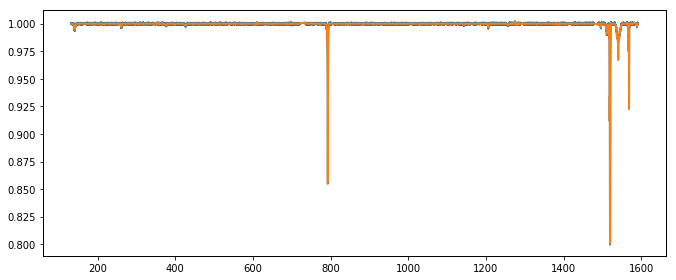

In [8]:
# check to see that the light curve still looks good
fig,ax = plt.subplots(figsize=(9.5,4))
ax.plot(data[:,0],data[:,2])
x,y = reduce_lc(data[:,0],data[:,2])
ax.plot(x,y)
fig.tight_layout()

### possible light cuves
These are used to explore the implications of each for the IR light curve.
- no secular dimming at all
- 3% secular dimming during Kepler mission
- 16% century-long dimming + 3% Kepler dimming
- 3% secular dimming during Kepler mission, where 16% dimming ends just before Kepler

('Light curve reduction:', 55882, '->', 1269, 'points')
('Light curve reduction:', 55882, '->', 1268, 'points')
('Light curve reduction:', 55882, '->', 1242, 'points')
('Light curve reduction:', 55882, '->', 1268, 'points')


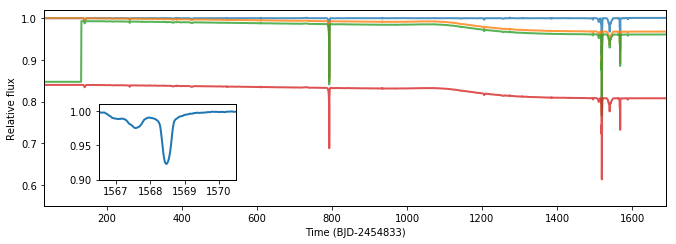

In [9]:
fig,ax = plt.subplots(figsize=(9.5,3.5),sharey=True)

alpha = 0.8

# no dimming
x,y = reduce_lc(data[:,0],data[:,2]-np.median(data[:50,2])+1,before=100,after=100)
ax.plot(x,y,alpha=alpha)
# Kepler dimming
x,y = reduce_lc(data[:,0],data[:,3]-np.median(data[:50,3])+1,before=100,after=100)
ax.plot(x,y,alpha=alpha)
# century dimming ends, Kepler dimming
x,y = reduce_lc(data[:,0],data[:,3]-np.median(data[:50,3])+0.993,before=100,after=100,before_lev=0.8475)
ax.plot(x,y,alpha=alpha)
# century dimming + Kepler dimming
x,y = reduce_lc(data[:,0],data[:,3]-np.median(data[:50,3])+1-0.16,before=100,after=100)
ax.plot(x,y,alpha=alpha)

ax.set_xlabel('Time (BJD-2454833)')
ax.set_ylabel('Relative flux')
ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(0.55,1.02)

fig.tight_layout()

ins = plt.axes([.15, .27, .2, .3])
ins.plot(data[:,0],data[:,2])
ins.set_xlim(1566.5,1570.5)
ins.set_ylim(0.9,1.01)

fig.savefig('lcs.pdf')

### the specific data used for everything below is selected here
The method used means that dust can only exist and contribute to the IR emission where there is an optical light curve. Specifically, near the ends of the light curve (probably) artificial effects are introduced, for example because the level of secular dimming effectively goes from a finite level to zero. Thus, the light curve is simply extrapolated backward/forward in time at a constant level that is the same as the last handful of data points.

The reason for adding 2000 (3500-1591) days is that this is enough so that the mid-IR light curves don't turn down near the beginning or end. There's an implicit assumption here (verified below) that the mid-IR flux is dominated by material near pericenter, so the whole orbit doesn't need to be filled out.

When we need to include mm fluxes, fill out the orbit with non-zero dimming as necessary.

('Light curve reduction:', 55887, '->', 2089, 'points')
('Light curve length:', 8.150204269337925, 'years')


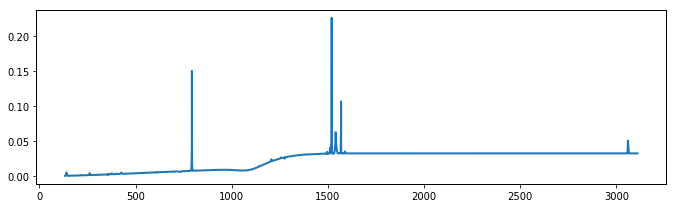

In [10]:
time = data[:,0]

# flux = data[:,2]-np.median(data[:50,2])+1      # flat light curve
flux = data[:,3]-np.median(data[:50,3])+1        # Kepler secular dimming
# flux = data[:,3]-np.median(data[:50,3])+1-0.16 # 16% + Kepler secular dimming

# flux = np.ones(len(time))-0.017     # something custom for testing

# time added at the start, extrapolating back 100 years
if 0:
    extra_time = np.arange(-365.25*100,np.min(time)-0.1,0.1)
    time = np.append(extra_time,time)
    flux = np.append(np.zeros(len(extra_time))+np.min(np.append(1,np.median(flux[0]))),flux)

# or secular dimming for previous 100 years
if 0:
    extra_time = np.arange(-365.25*100,np.min(time)-0.1,10)
    time = np.append(extra_time,time)
    flux = np.append(np.linspace(1,0.84,num=len(extra_time)),flux)

# time added on end
if 0:
    extra_time = np.arange(np.max(time)+0.1,np.max(time)+2000,10)
    time = np.append(time,extra_time)
    flux = np.append(flux,np.zeros(len(extra_time))+np.min(np.append(1,np.median(flux[-1]))))

# time added on the end, completing orbit
if 0:
    extra_time = np.arange(np.max(time)+0.1,365.25*111.55,10)
    time = np.append(time,extra_time)
    flux = np.append(flux,np.linspace(np.min(np.append(1,np.median(flux[-1]))),flux[0],num=len(extra_time)))

# add May 2017 dip
if 1:
#     time = np.append(time,np.max(time)+0.1)
#     flux = np.append(flux,1)
    flux_dip = np.array([1,1,0.98,1,1],dtype=float) + flux[-1] - 1
    time_dip = np.array([-2,-1.5,0,5,50],dtype=float) + 2457893.0 - 2454833
    time = np.append(time,time_dip)
    flux = np.append(flux,flux_dip)
    
time,flux = reduce_lc(time,flux)

# we're going to use the time between two measurements to generate a line element of dust
dt = time[1:] - time[:-1]                   # duration of each section
time = (time[1:] + time[:-1])/2.0           # mean time of a section of light curve
flux = (flux[1:] + flux[:-1])/2.0           # mean flux in this section

# this is the fractional dimming of the star, zero is no dimming
delta = 1 - flux

fig,ax = plt.subplots(figsize=(9.5,3),sharey=True)
ax.plot(time,delta)
fig.tight_layout()

print("Light curve length:",(np.max(time)-np.min(time))/365.25,'years')

## geometry setup
Here the specifics of where the dust passes in front of the star are set up.

### orbit setup
Here an orbit is defined, and a few handy other things derived. At this point the period of the orbit should be longer than the length of the Kepler light curve, otherwise it wraps around more than a single orbit, and with this setup there would be an inconsistency where one point on the orbit has two different flux (and hence dust) levels.

In [11]:
e = 0.9975           # eccentricity
q = 0.1              # pericenter (au), 0.1au is good with Kepler dimming
w = 0.0 *np.pi/180.  # pericenter (from los)

def orbit_par(q,e=0.99,w=0.0):
    """Some things implied by a given orbit."""
    
    a = q / (1.0 - e)    # semi-major axis

    rt = q * (1+e) / (1+e*np.cos(w))             # distance at transit
    h = np.sqrt(mstar * q * (1+e))               # specific angular momentum

    n = 2 * np.pi * np.sqrt(mstar/a**3) / 365.25 # mean motion, rad/day
    vt = 29.78e3 * h / rt * secperday / mperau   # projected velocity at transit, au/day
    per = 2*np.pi/n                              # period in days
    
    return a,rt,h,n,vt,per

a,rt,h,n,vt,per = orbit_par(q,e,w)

print("a (au):",a)
print("rt (au):",rt)
print("vt (au/day):",vt)
print("per (days):",per)
print("per (years):",per/365.25)

('a (au):', 40.00000000000085)
('rt (au):', 0.1)
('vt (au/day):', 0.09192174391791764)
('per (days):', 77270.22784933726)
('per (years):', 211.55435413918482)


In [12]:
def get_Om(inc,rstar,kappa,rt,verb=True):
    """Get the star-covering fraction.
    inc : inclination in radians
    rstar : stellar radius in au
    kappa : angular half-height of dust distribution in radians
    """
    bl = (inc-kappa)*rt
    bu = (inc+kappa)*rt
    if verb and ( np.min(bl) <= -rstar or np.max(bu) >= rstar ):
        print('WARNING: dust above/below star!')

    Om = 1.0/np.pi * ( np.arccos(bl/rstar)-(bl/rstar)*np.sqrt(1-(bl/rstar)**2)
                      - np.arccos(bu/rstar)+(bu/rstar)*np.sqrt(1-(bu/rstar)**2) )
    return Om

### choosing kappa
This plots shows a complicated dependence of dsig/dt on kappa. In the simple case of geometrical optical depth dsig/dt would be proportional to kappa*delta/Omega, and Omega oc kappa so the kappa dependence cancels out. For exponential optical depth, when tau is high (i.e. kappa is low) things become non-linear and dsig/dt (i.e. the amount of dust) increases more strongly than we'd expect. So setting kappa to be low requires much more dust than we might expect (it's optically thicker so we get less bang for our buck worth of dust), and it makes more sense to have it (and the covering fraction of the star Omega) be relatively large. There is also no doubt a dependence on how much of the star is blocked, since for a large fraction (higher kappa) there can be a lot of dust that exists, but does not affect the stellar flux much because it has a large impact parameter.

('min kappa', 0.013032363072633332)
('kappa(min dsigdt,i=0):', 0.0467210365759984)


/usr/local/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arccos
  del sys.path[0]
/usr/local/miniconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in sqrt
  del sys.path[0]
/usr/local/miniconda2/envs/astroconda/lib/python2.7/site-packages/matplotlib/scale.py:114: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


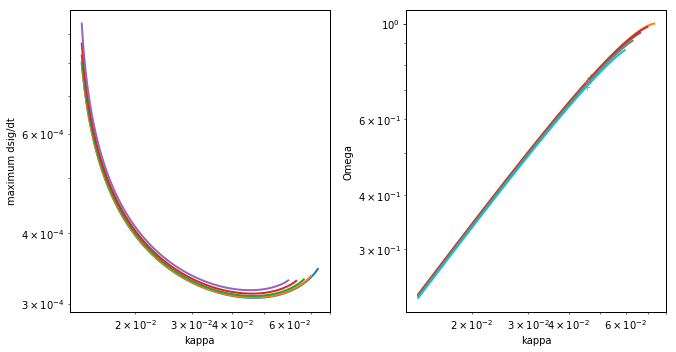

In [13]:
kappa_min = np.max(delta)*np.pi/4.*rstar/rt
print("min kappa",kappa_min)

fig,ax = plt.subplots(1,2,figsize=(9.5,5))
kaps = 10**np.arange(np.log10(kappa_min*1.05),np.log10(rstar/rt),0.0001)
for i in np.arange(0,1.,0.2)*np.pi/180.0:
    oms = get_Om(i,rstar,kaps,rt,verb=False)
    dsigdt = -2.*kaps*rt*vt*np.log(1-np.max(delta)/oms)
    min_om = np.nanargmin(dsigdt)
    if i == 0.0:
        kappa_opt = kaps[min_om]
        print('kappa(min dsigdt,i=0):',kappa_opt)
    ax[0].loglog(kaps,dsigdt)
    ax[1].plot(kaps[min_om],oms[min_om],'+')
    ax[1].loglog(kaps,oms)
    
ax[0].set_xlabel('kappa')
ax[0].set_ylabel('maximum dsig/dt')
ax[1].set_xlabel('kappa')
ax[1].set_ylabel('Omega')

fig.tight_layout()

The lesson from above is that too small, or too large, kappa, "loses" dust, either because it is optically thick or because it doesn't block much of the star out. Things change a bit if the inclination isn't zero too, as shown by lines above the lowest in the left panel. While the over trends are the same, the number change for different orbits, because r_t changes. Thus, take the minimum value for zero inclination.

In [14]:
inc = 0.
kappa = kappa_opt
Om = get_Om(inc,rstar,kappa,rt)

print("kappa (rad):",kappa)
print("kappa (deg):",kappa * 180./np.pi)
print("Om:",Om)
print("max(delta/Om):",np.max(delta/Om))
print("tau max:",-np.log(1 - np.max(delta)/Om))

('kappa (rad):', 0.0467210365759984)
('kappa (deg):', 2.6769182102810594)
('Om:', 0.7511410961376187)
('max(delta/Om):', 0.3006521188464242)
('tau max:', 0.3576069764982039)


## Surface area passing the star
With the geometry and the orbit set up, now calculate the area of dust (or whatever) going past the star per unit time (dsigdt) and the area of dust in each section of the light curve (sig).

The factor of 2.1 is Q_ext = Q_abs+Q_sca, which is roughly 2 because the dust both absorbs (Q_abs~1) and scatters (Q_sca~1) light.

There should be another factor here that accounts for the optical depth of the dust, since that lowers how much radiation it receives and therefore the IR flux.

In [15]:
Q_ext = 2.14

dsigdt = -2.0*kappa*rt*vt*np.log(1-delta/Om) / Q_ext # area passing in front of star / unit time
sig = dsigdt * dt

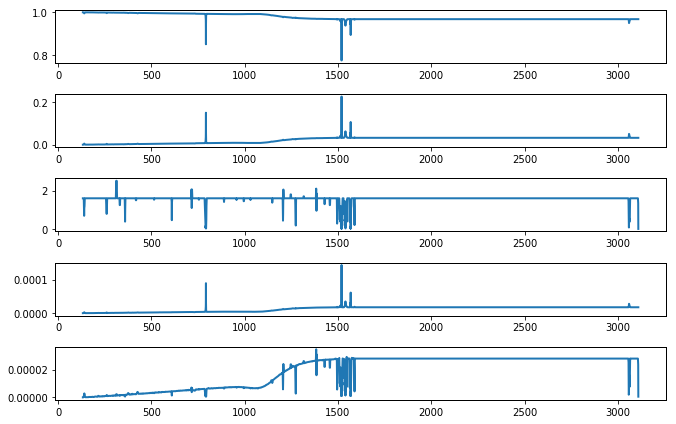

In [16]:
# a plot of the light curve to use, the deltas, the dts, dsigdt, and sig
fig,ax = plt.subplots(5,figsize=(9.5,6))
ax[0].plot(time,flux)
ax[1].plot(time,delta)
ax[2].plot(time,dt)
ax[3].plot(time,dsigdt)
ax[4].plot(time,sig)
fig.tight_layout()

## IR flux at some time
The IR flux is calculated using P(r) = Q_abs x B_nu(r). Q_abs is the optical properties of the dust, and B_nu(r) is the Plank function for the temperature of the dust at some radius r, which is calculated self consistently using Q_abs.

In [17]:
pr_arr = np.loadtxt('pr-astrosil.txt')
pr_wav = pr_arr[0,:-1]
pr_rad = pr_arr[1:,-1]
pr_arr = pr_arr[1:,:-1]

def pr_func(wave,radius):
    """Return array of interpolated P(r). One of wave or radius must be a number, the other an array."""
#     f = interp2d(pr_wav,pr_rad,pr_arr,bounds_error=True,copy=False)
#     return f(wave,radius).squeeze()

    f = RectBivariateSpline(pr_rad,pr_wav,pr_arr)
    return f(radius,wave,grid=False).squeeze()

In [18]:
def lc_flux(par,a=a,e=e,w=w,n=n,time=time,sig=sig,bb=False):
    """Compute the IR flux at a given wavelength at a specific time.
    
    The dust distribution derived above (sig) is placed at the appropriate location
    around the orbit given the time, and the emission from each section found and summed.
    
    Other variables are taken from earlier in the script.
    """
    wav,t0 = par
    
    M_p = convfm(w,e)   # mean anomaly of transit w.r.t. pericenter
    t_p = M_p/n         # time from transit to pericenter
    
    t = t0 - time + t_p # time since chunk pericenter passage of lc chunk (-ve means yet to)

    M = n * t # mean anomaly
    f = np.zeros(len(M))
    for i,ma in enumerate(M):
        f[i] = convmf(ma,e)   # true anomaly, angle past pericenter

    r = a * (1-e**2) / (1+e*np.cos(f)) # radius of each section of the light curve
    
    # the flux at each specific distance
    if bb:
        temp = 278.3 / np.sqrt(r) * lstar **0.25
        flux_time = 2.35e-11 / dist**2 * bnu(wav,temp)
    else:
        # P(r) already includes solid angle component
        flux_time = pr_func(wav,r)
        
    flux_time *= sig
    
    tot_flux = np.sum(flux_time) # total flux around the light curve at this time
    
    return t,r,f,flux_time,tot_flux

def lc_tot_flux(par,bb=False):
    """Return just the total flux from above."""
    _,_,_,_,tot = lc_flux(par,bb=bb)
    return tot

### Where flux comes from
A check of the P(r) routine compared to blackbody, for 22um. The top panel shows the flux from each light curve section as a function of true anomaly. The bottom panel shows the cumulative sum of the flux against radius, that most of the increase from zero occurs at small radii (within ~10au) indicates that pericenter dominates. This domination is much stronger at shorter wavelengths.

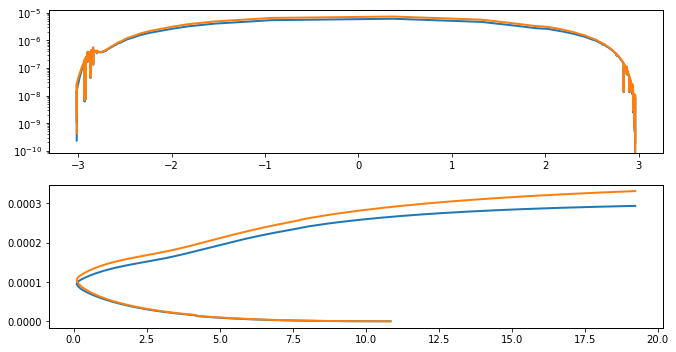

In [19]:
t1,r1,f1,flux_time1,tot_flux1 = lc_flux([22,1000],bb=True)
t2,r2,f2,flux_time2,tot_flux2 = lc_flux([22,1000],bb=False)

fig,ax = plt.subplots(2,figsize=(9.5,5))
ax[0].semilogy(f1,flux_time1)
ax[0].semilogy(f2,flux_time2)

ax[1].plot(r1,np.cumsum(flux_time1))
ax[1].plot(r2,np.cumsum(flux_time2))

fig.tight_layout()

### orbit
The section of the orbit for which dust exists, red shows where this dust is when the light curve begins, and blue when it ends. The orbit is viewed from the right, so for w=0 pericenter will be facing in that direction. An offset has been added to show the differences in distribution between start and finish.

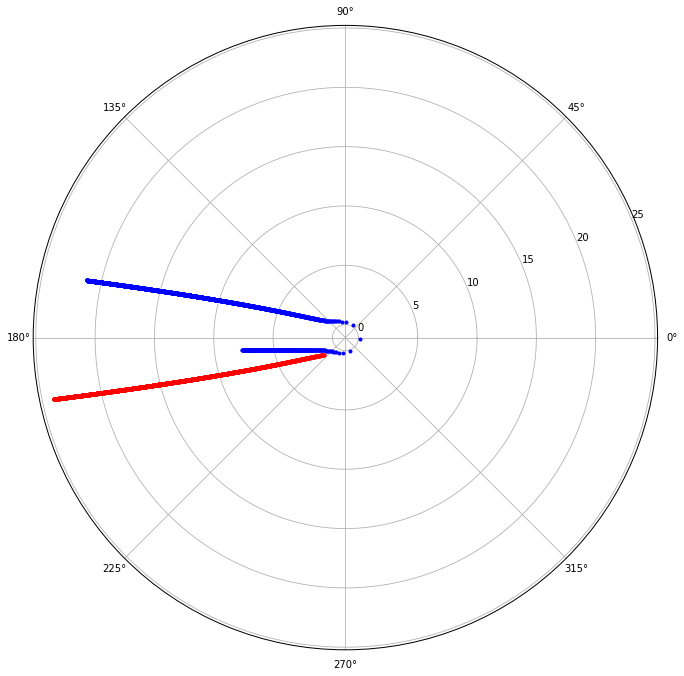

In [20]:
t,r1,f1,f_t,tot = lc_flux([12,100])
t,r2,f2,f_t,tot = lc_flux([12,2600])

fig,ax = plt.subplots(figsize=(9.5,9.5),subplot_kw=dict(projection='polar'))
ax.plot(f1+w+0.1,r1,'.',color='red')
ax.plot(f2+w-0.1,r2,'.',color='blue')
# ax.plot(f1[0]+w+0.1,r1[0],'og')
# ax.plot(f1[-1]+w-0.1,r1[-1],'xg')
fig.tight_layout()

### spectra at some different times

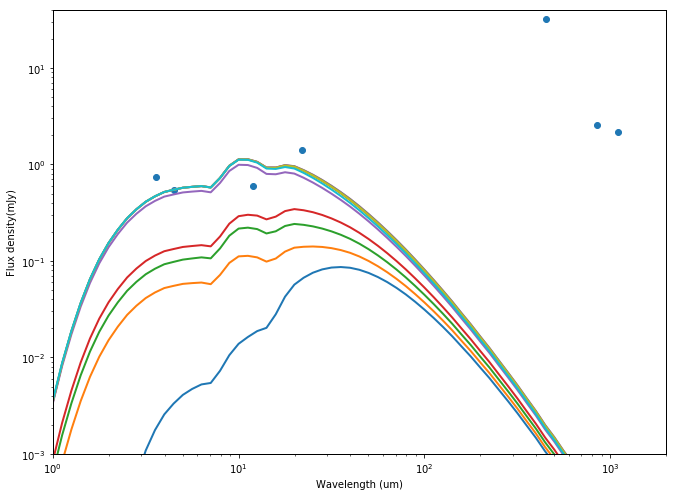

In [21]:
fig,ax = plt.subplots(figsize=(9.5,7))
wav_obs = [3.6,4.5,12,22,450,850,1100]
lim_obs = [.75,.54,.6,1.4,32.1,2.55,2.19]
ax.scatter(wav_obs,lim_obs)
ax.set_ylim(0.001,40)
ax.set_xlim(1,2000)
ax.set_xlabel('Wavelength (um)')
ax.set_ylabel('Flux density(mJy)')

for t in np.arange(np.min(time),np.max(time),(np.max(time)-np.min(time))/10.):
    wav = 10**np.arange(0,3.3,0.05)
    pars = np.column_stack((wav,np.zeros(len(wav))+t))
    pool = Pool(processes=8)
    f_tot = pool.map(lc_tot_flux,pars)
    pool.close()
    ax.loglog(wav,np.array(f_tot)*1e3)
    
fig.tight_layout()

### IR observations
These are mostly the WISE observations, dates loaded from epoch photometry. Also include the SpiKeS observation.

In [22]:
t = Table.read('wise-epoch.tbl',format='ascii.ipac')
t['date_obs'] = t['mjd'] + 2400000.5 - 2454833.0

t36 = t['date_obs'][t['w1mpro_ep'].mask == False].tolist()
lim36 = np.zeros(len(t36))+1e-3*2.0
t45 = t['date_obs'][t['w2mpro_ep'].mask == False].tolist()
lim45 = np.zeros(len(t45))+1e-3*1.0
t12 = t['date_obs'][t['w3mpro_ep'].mask == False].tolist()
lim12 = np.zeros(len(t12))+1e-3*0.66
t22 = t['date_obs'][t['w4mpro_ep'].mask == False].tolist()
lim22 = np.zeros(len(t22))+1e-3*2.11

t = Table.read('wise-react-epoch2.tbl',format='ascii.ipac')
t['date_obs'] = t['mjd'] + 2400000.5 - 2454833.0
t36r = t['date_obs'][t['w1mpro'].mask == False].tolist()
lim36r = np.zeros(len(t36r))+1e-3*2.0
t45r = t['date_obs'][t['w2mpro'].mask == False].tolist()
lim45r = np.zeros(len(t45r))+1e-3*1.0

t36 = np.append(t36,t36r)
t45 = np.append(t45,t45r)
lim36 = np.append(lim36,lim36r)
lim45 = np.append(lim45,lim45r)

t36 = np.append(t36,2457040.5-2454833.0)
t45 = np.append(t45,2457040.5-2454833.0)
lim36 = np.append(lim36,1e-3*0.75)
lim45 = np.append(lim45,1e-3*0.54)

t11 = np.array([2457336.5-2454833.0])
lim11 = np.array([0.00219])

wavobs = [3.6,4.5,12,22,1100]
dobs = (t36,t45,t12,t22,t11)
fobs = (lim36,lim45,lim12,lim22,lim11)

### flux at some wavelength as a function of time

In [23]:
# t = np.arange(np.min(time),np.max(time),1)
t = np.arange(100,3150,1)

f_array = np.zeros((len(wavobs),len(t)))
for i,wav in enumerate(wavobs):
    wavs = np.zeros(len(t)) + wav
    pars = np.column_stack((wavs,t))
    pool = Pool(processes=8)
    f_tot = pool.map(lc_tot_flux,pars)
    pool.close()
    f_array[i,:] = f_tot
    
np.savez('ft-q'+str(q)+'e'+str(e),time=time,flux=flux,t=t,f_array=f_array)

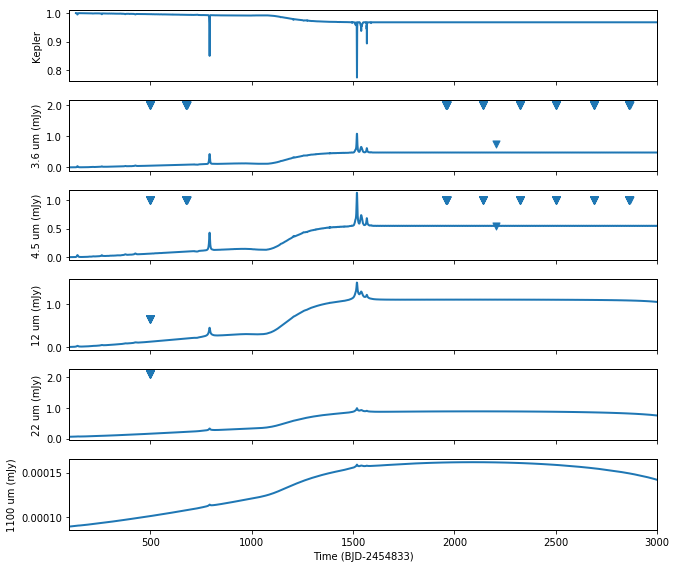

In [24]:
fig, ax = plt.subplots(6,figsize=(9.5,8),sharex=True)
ax[0].plot(time,flux)

ax[0].set_ylabel('Kepler')
ax[-1].set_xlabel('Time (BJD-2454833)')
ax[0].set_xlim(100,3000)
fig.subplots_adjust(hspace=0.1)

for i,wav in enumerate(wavobs):
    f_tot = f_array[i,:]
    ax[i+1].plot(t,1e3*f_tot)
    ax[i+1].set_ylabel(str(wav)+' um (mJy)')
    if i < 4:
        ax[i+1].scatter(dobs[i],np.zeros(len(dobs[i]))+fobs[i]*1e3,marker='v',s=50)
        ax[i+1].yaxis.set_major_formatter( matplotlib.ticker.FormatStrFormatter('%3.1f') )
    
fig.tight_layout()
# fig.savefig('ir-lc.pdf')

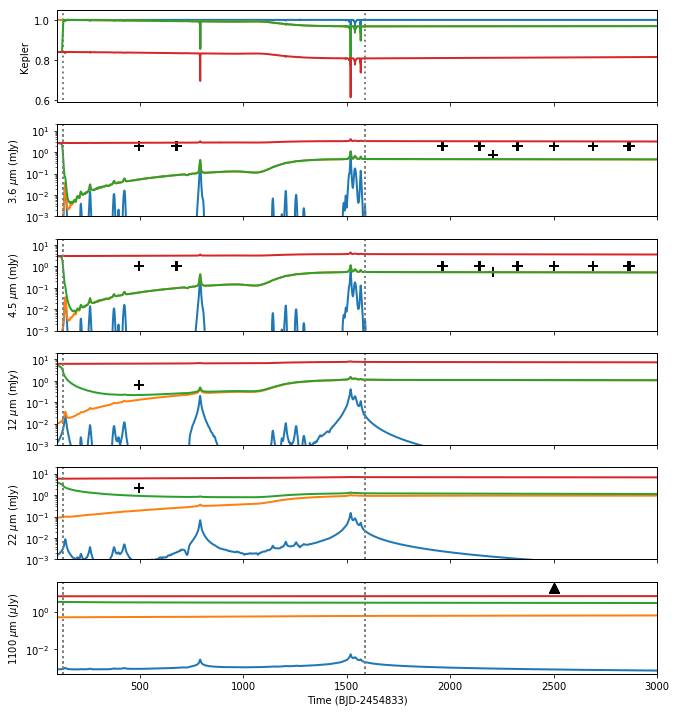

In [25]:
# combine several runs of the previous to generate a compiled plot

# files for Q_ext=1
# files = ['ft-q0.2e0.995-nd.npz','ft-q0.2e0.995-kd.npz','ft-q0.2e0.995-cekd.npz','ft-q0.2e0.995-ckd.npz']

# files for Q_ext=2.14
files = ['ft-q0.1e0.9975-nd.npz','ft-q0.1e0.9975-kd.npz','ft-q0.1e0.9975-cekd.npz','ft-q0.1e0.9975-ckd.npz']
# files = ['ft-q0.1e0.9975-nd-may17.npz','ft-q0.1e0.9975-kd-may17.npz','ft-q0.1e0.9975-cekd.npz','ft-q0.1e0.9975-ckd.npz']

fig, ax = plt.subplots(6,figsize=(9.5,10),sharex=True)

s = np.load('ft-q0.1e0.9975-kd.npz')
# ax[0].plot(s['time'],s['flux'],color='C1')
# ax[0].plot(time,flux)

ax[0].set_ylabel('Kepler')
ax[-1].set_xlabel('Time (BJD-2454833)')
ax[0].plot([131,131],[0.6,1.1],':',color='grey')
ax[0].plot([1591,1591],[0.6,1.1],':',color='grey')
ax[0].set_ylim(0.59,1.05)
ax[0].set_xlim(100,3000)
fig.subplots_adjust(hspace=0.1)

log = 1

for f in files:
    
    s = np.load(f)
    t = s['t']
    f_arr = s['f_array']

    ax[0].plot(s['time'],s['flux'])

    for i,wav in enumerate([3.6,4.5,12,22,1100]):
        f_tot = f_arr[i,:]
        ax[i+1].yaxis.set_major_formatter( matplotlib.ticker.FormatStrFormatter('%3.1f') )
        if i < 4:
            if log:
                ax[i+1].semilogy(t,1e3*f_tot)
                ax[i+1].set_ylim(1e-3,20)
            else:
                ax[i+1].plot(t,1e3*f_tot)
                
            ax[i+1].set_ylabel(str(wav)+' $\mu$m (mJy)')
            ax[i+1].scatter(dobs[i],np.zeros(len(dobs[i]))+fobs[i]*1e3,marker='+',s=100,color='black')
        else:
            if log:
                ax[i+1].semilogy(t,1e6*f_tot)
                ax[i+1].set_ylim(5e-4,40)
                ax[i+1].scatter(dobs[i],18.95,marker='^',s=100,color='black')
            else:
                ax[i+1].plot(t,1e6*f_tot)
                ax[i+1].set_ylim(-0.1,9)
                ax[i+1].scatter(dobs[i],8.95,marker='^',s=100,color='black')
                    
            ax[i+1].set_ylabel(str(wav)+' $\mu$m ($\mu$Jy)')

        ax[i+1].plot([131,131],ax[i+1].get_ylim(),':',color='grey')
        ax[i+1].plot([1591,1591],ax[i+1].get_ylim(),':',color='grey')

fig.tight_layout()
if log:
    fig.savefig('ir-4lc-log.pdf')
else:
    fig.savefig('ir-4lc.pdf')

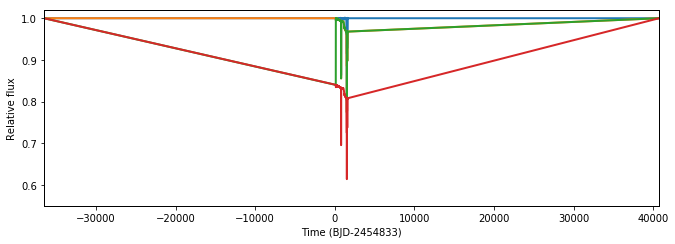

In [26]:
fig, ax = plt.subplots(figsize=(9.5,3.5))

ax.set_ylabel('Kepler')
ax.set_xlabel('Time (BJD-2454833)')
# ax[0].set_xlim(100,2600)

for f in files:   
    s = np.load(f)
    ax.plot(s['time'],s['flux'])

ax.set_xlabel('Time (BJD-2454833)')
ax.set_ylabel('Relative flux')
ax.set_xlim(np.min(s['time']),np.max(s['time']))
ax.set_ylim(0.55,1.02)

fig.tight_layout()

fig.savefig('lcs-full.pdf')

# May 2017 dip
What should the IR light curve look like? Eyeballing the LCO photometry the ingress is 1.5d, the egress 5d, and the max depth 2%. So the integrated dip is 6.5 % days.

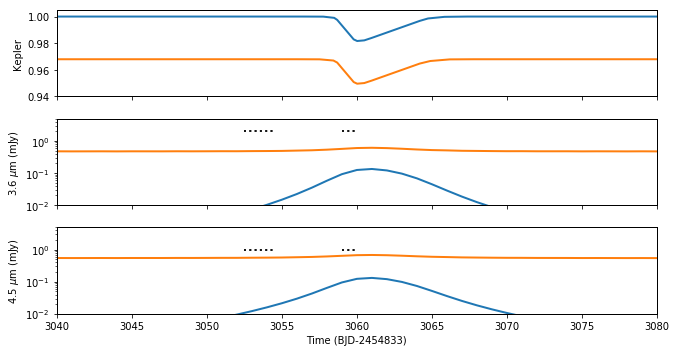

In [27]:
fig, ax = plt.subplots(3,figsize=(9.5,5),sharex=True)

files = ['ft-q0.1e0.9975-nd-may17.npz','ft-q0.1e0.9975-kd-may17.npz']

ax[0].set_ylabel('Kepler')
ax[-1].set_xlabel('Time (BJD-2454833)')
ax[0].set_xlim(3040,3080)
ax[0].set_ylim(0.94,1.005)
# ax[3].set_ylabel('W1-W2 colour')
# ax[3].set_ylim(0,0.25)

fig.subplots_adjust(hspace=0.1)

log = 1
cols = ['C0','C1']
wise_obs1 = 2400000.5 + 57885 + np.array([0,2]) - 2454833
wise_obs2 = 2400000.5 + 57885 + np.array([6.5,7.5]) - 2454833
# wise_obs = [3053,3063]

for f in files:
    
    s = np.load(f)
    t = s['t']
    f_arr = s['f_array']

    ax[0].plot(s['time'],s['flux'])

#     dmag = -2.5*np.log10((2.048+f_arr[0,:])/307.09) + 2.5*np.log10((1.154+f_arr[1,:])/170.83)
#     ax[3].plot(t,dmag)
    
    for i,wav in enumerate([3.6,4.5]):
        f_tot = f_arr[i,:]
        ax[i+1].yaxis.set_major_formatter( matplotlib.ticker.FormatStrFormatter('%3.1f') )
        if log:
            ax[i+1].semilogy(t,1e3*f_tot)
            ax[i+1].set_ylim(1e-2,5)
        else:
            ax[i+1].plot(t,1e3*f_tot)

        ax[i+1].set_ylabel(str(wav)+' $\mu$m (mJy)')
        if i == 0:
            ax[i+1].plot(wise_obs1,[2,2],':',color='black',alpha=0.7)
            ax[i+1].plot(wise_obs2,[2,2],':',color='black',alpha=0.7)
        else:
            ax[i+1].plot(wise_obs1,[1,1],':',color='black',alpha=0.7)
            ax[i+1].plot(wise_obs2,[1,1],':',color='black',alpha=0.7)

fig.tight_layout()
if log:
    fig.savefig('ir-2lc-log.pdf')
else:
    fig.savefig('ir-2lc.pdf')

## Parameter space
How does the IR flux change for different pericenter distances and dip depths/durations?

In [28]:
def quick_lc(depth=0.1,shape='box',width=1,width2=None,w=0,pad=0,dt=None):
    """Make a small section of light curve with a dip, return delta"""
    
    if width2 is None:
        width2 = width
    if dt is None:
        dt = np.min([width/50.,width2/50.,0.1])
    time = np.arange(-width-pad,width2+pad,dt)
    dt = np.zeros(len(time)) + dt
    if shape == 'box':
        flux = np.ones(len(time))
        flux[np.logical_and(time > -width/2.,time < width2/2.)] = 1 - depth
    elif shape == 'tri':
        flux_tmp = [1,1,1-depth,1,1]
        time_tmp = [-pad-width,-width,0,width2,width2+pad]
        flux = np.interp(time,time_tmp,flux_tmp)
        
    return time,dt,flux


def max_flux(wav=3.6,depth=0.1,width=1,q=0.1,e=0.99,w=0):
    """Get the maximum flux for a dip, assuming flux is dominated by material near pericenter.
    The flux is computed only when the material is near pericenter."""

    # orbit and geometry, 
    a,rt,h,n,vt,per = orbit_par(q,e=e,w=w)
    kappa = 0.8 * np.pi / 4. * rstar / rt
    Om = get_Om(0.0,rstar,kappa,rt)
    
    M_p = convfm(w,e)   # mean anomaly of transit w.r.t. pericenter
    t_p = M_p/n         # time from transit to pericenter

    time, dt, flux = quick_lc(depth=depth,width=width,w=w)
    delta = 1 - flux
    
    # dust area
    dsigdt = -2.0*kappa*rt*vt*np.log(1-delta/Om) / 2.14 # area passing in front of star / unit time
    sig = dsigdt * dt
    
    # flux when dust passes pericenter
    t,r,f,flux_time,tot_flux = lc_flux([wav,-t_p],a=a,e=e,w=w,n=n,time=time,sig=sig,bb=False)
    
    return t,flux_time,tot_flux

('total flux:', 0.00012802673018593458)


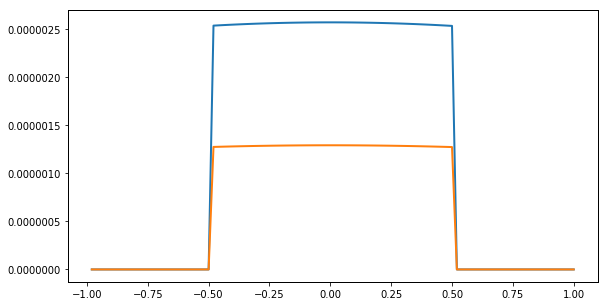

In [29]:
# a quick test
t,f,tf = max_flux(q=0.2,width=1,depth=0.2,w=0)
t1,f1,tf1 = max_flux(q=0.2,width=1,depth=0.2,w=np.pi/2.)

fig, ax = plt.subplots(figsize=(9.5,5))
ax.plot(t,f)
ax.plot(t1,f1)
print('total flux:',tf)

Some experimentation finds that different combinations that have the same depth x width product don't produce exactly the same maximum flux, there are differences of a few tens of percent. This is because the material is spread out slightly differently, and for a wider dip is less concentrated so produces a lower maximum flux. Thus, for small pericenter distances more IR flux results for a deeper narrow dip than a longer shallow dip.

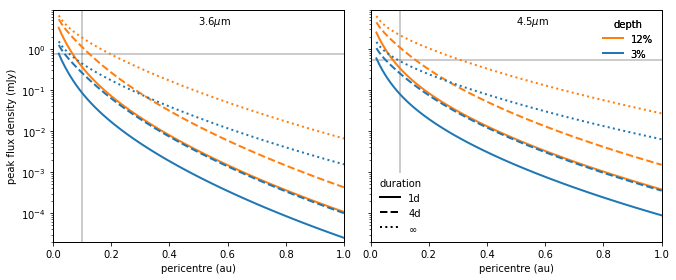

In [30]:
# now some loops to make the plot
qs = np.arange(0.02,1.01,0.01)

peri = 0.0

ls = ['-','--',':']
col = ['C0','C1','C2']

fig, ax = plt.subplots(1,2,figsize=(9.5,4),sharey=True)

if 1:
    ds = [0.03,0.12]
    ws = [1,4,500]
    # lines of Spitzer sensitivity
    ax[0].plot([0,1],np.ones(2)*0.75,color='black',alpha=0.2)
    ax[1].plot([0,1],np.ones(2)*0.54,color='black',alpha=0.2)
    # lines of 0.1au pericenter
    ax[0].plot([0.1,0.1],[2e-5,10],color='black',alpha=0.2)
    ax[1].plot([0.1,0.1],[1e-3,10],color='black',alpha=0.2)
else:
    ds = [0.02]
    ws = [3.25]
    # lines of WISE sensitivity
    ax[0].plot([0,1],np.ones(2)*2,color='black',alpha=0.2)
    ax[1].plot([0,1],np.ones(2)*1,color='black',alpha=0.2)
    # lines of 0.1au pericenter
    ax[0].plot([0.1,0.1],[2e-5,10],color='black',alpha=0.2)
    ax[1].plot([0.1,0.1],[2e-4,10],color='black',alpha=0.2)

for i,w in enumerate(ws):
    for j,d in enumerate(ds):
        fl1 = []
        fl2 = []
        for q in qs:
            _,_,f = max_flux(wav=3.6,depth=d,width=w,q=q,w=peri)
            fl1.append(f*1e3)
            _,_,f = max_flux(wav=4.5,depth=d,width=w,q=q,w=peri)
            fl2.append(f*1e3)
        ax[0].semilogy(qs,fl1,ls[i],color=col[j])
        ax[1].semilogy(qs,fl2,ls[i],color=col[j])
      
ax[0].set_xlim(0,1)
ax[1].set_xlim(0,1)
ax[0].set_ylim(2e-5,9)

# labels etc.
ax[0].text(0.5,4,'3.6$\mu$m')
ax[1].text(0.5,4,'4.5$\mu$m')
ax[0].set_xlabel('pericentre (au)')
ax[1].set_xlabel('pericentre (au)')
ax[0].set_ylabel('peak flux density (mJy)')

l1 = matplotlib.lines.Line2D([],[],linestyle=ls[0],color='black')
l2 = matplotlib.lines.Line2D([],[],linestyle=ls[1],color='black')
l3 = matplotlib.lines.Line2D([],[],linestyle=ls[2],color='black')
leg1 = plt.legend(handles=[l1,l2,l3],labels=[str(ws[0])+'d',
                                             str(ws[1])+'d',
                                             '$\infty$'],
                  title='duration',frameon=False,loc=3)

l4 = matplotlib.lines.Line2D([],[],color=col[1])
l5 = matplotlib.lines.Line2D([],[],color=col[0])
leg2 = plt.legend(handles=[l4,l5],labels=[str(int(100*ds[1]))+'%',
                                          str(int(100*ds[0]))+'%'],title='depth',frameon=False,loc=1)

plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)

fig.tight_layout()
fig.savefig('irflux_q.pdf')

# and now time-resolved versions

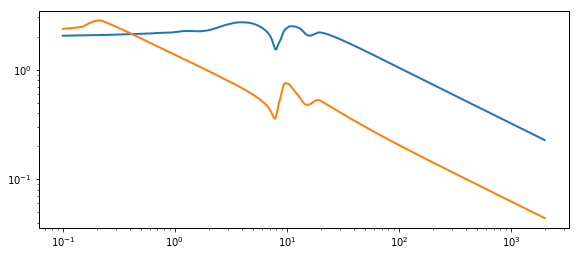

In [31]:
# we need extinction as a function of wavelength
wave_ext,q_ext = np.genfromtxt('q_ext_astrosil_2p7um.txt',usecols=[0,1],unpack=True)
wave_ext_01,q_ext_01 = np.genfromtxt('q_ext_astrosil_0p1um.txt',usecols=[0,1],unpack=True)
fig, ax = plt.subplots(figsize=(9.5,4))
ax.loglog(wave_ext,q_ext)
ax.loglog(wave_ext_01,q_ext_01)

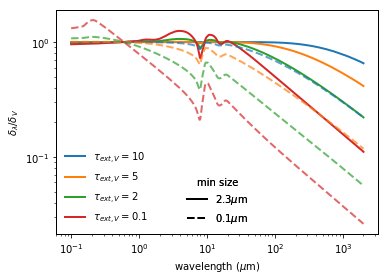

In [32]:
# plot (1-delta_lambda)/(1-delta_V)
fig, ax = plt.subplots(figsize=(5.5,4))

q_ext_V = np.interp(0.6,wave_ext,q_ext)
q_ext_V_01 = np.interp(0.6,wave_ext_01,q_ext_01)

cols = ['C0','C1','C2','C3']

tau_ext_Vs = [10,5,2,0.1]

for i,tau_ext_V in enumerate(tau_ext_Vs):
        x = (1-np.exp(-tau_ext_V * q_ext / q_ext_V)) / (1-np.exp(-tau_ext_V))
        ax.loglog(wave_ext,x,label=r'$\tau_{ext,V}=$'+str(tau_ext_V),color=cols[i])

for i,tau_ext_V in enumerate(tau_ext_Vs):
        x = (1-np.exp(-tau_ext_V * q_ext_01 / q_ext_V_01)) / (1-np.exp(-tau_ext_V))
        ax.loglog(wave_ext_01,x,'--',color=cols[i],alpha=0.7)
        
ax.set_xlabel('wavelength ($\mu$m)')
ax.set_ylabel('$\delta_\lambda / \delta_V$')
# ax.legend(frameon=False)

ls = [matplotlib.lines.Line2D([],[],color=c) for c in cols]
labs = [r'$\tau_{ext,V}=$'+str(tau) for tau in tau_ext_Vs]
leg1 = ax.legend(handles=ls,labels=labs,frameon=False,loc=3)

l1 = matplotlib.lines.Line2D([],[],color='black',linestyle='-')
l2 = matplotlib.lines.Line2D([],[],color='black',linestyle='--')
leg2 = ax.legend(handles=[l1,l2],labels=['2.3$\mu$m','0.1$\mu$m'],title='min size',frameon=False,loc=8)

plt.gca().add_artist(leg1)
plt.gca().add_artist(leg2)

fig.tight_layout()
fig.savefig('d_lam-d_kep.pdf')

In [40]:
def lc_flux_quick(wav=3.6,q=0.1,e=0.99,w=0,dt=0.5,plot=False):
    """Get the flux over time for a dip, assuming flux is dominated by material near pericenter."""

    # orbit and geometry, 
    a,rt,h,n,vt,per = orbit_par(q,e=e,w=w)
    kappa = 0.8 * np.pi / 4. * rstar / rt
    Om = get_Om(0.0,rstar,kappa,rt)
        
    # dust area
#     time, dt, f_V = quick_lc(depth=0.03,width=100,pad=5,dt=dt,w=w)
    time, dt, f_V = quick_lc(depth=0.02,width=3.25,width2=3.25,pad=100,shape='tri',dt=dt,w=w)
    dsigdt = -2.0*kappa*rt*vt*np.log(1-(1-f_V)/Om) / 2.14 # area passing in front of star / unit time
    sig = dsigdt * dt
    
    # IR light curve
    q_ext_lam = np.interp(wav,wave_ext,q_ext)
    q_ext_V = np.interp(0.6,wave_ext,q_ext)
    tau_ext_lam = q_ext_lam * dsigdt / (2 * kappa * h)
    tau_ext_V = q_ext_V * dsigdt / (2 * kappa * h)
    ok = np.where(dsigdt > 0)[0]
    f_lam = f_V
    x = (1-np.exp(-tau_ext_lam[ok]))/(1-np.exp(-tau_ext_V[ok]))
    f_lam[ok] = f_V[ok] * x / (q_ext_lam/q_ext_V)
            
    # flux when dust passes pericenter
    th_flux = np.zeros(len(time))
    for i,t in enumerate(time):
        t,r,f,flux_time,th_flux_tmp = lc_flux([wav,t],a=a,e=e,w=w,n=n,time=time,sig=sig,bb=False)
        th_flux[i] = th_flux_tmp
    
    return time,f_V,f_lam,th_flux*1e3

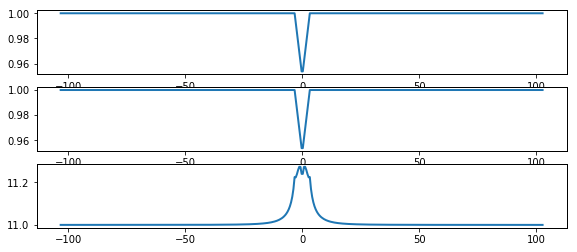

In [34]:
t,f_opt,f_ir,f_th = lc_flux_quick(wav=4.5,q=0.05)
fig, ax = plt.subplots(3,figsize=(9.5,4))
ax[0].plot(t,f_opt)
ax[1].plot(t,f_ir)
ax[2].plot(t,(f_ir*11. + f_th))

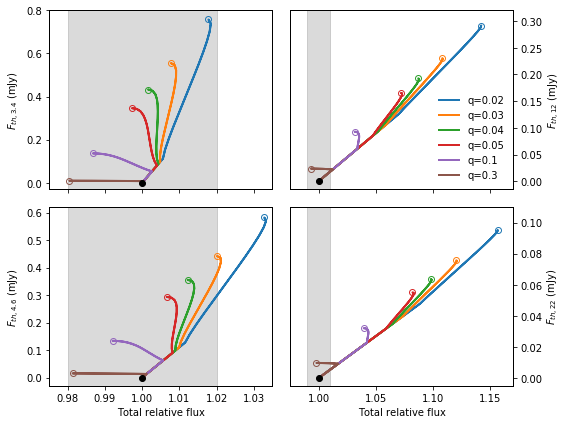

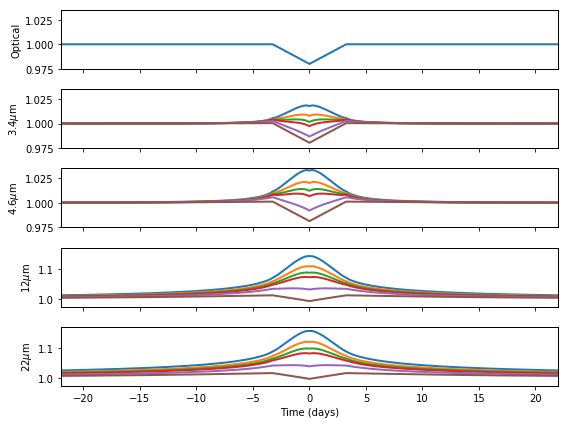

In [41]:
fig,ax = plt.subplots(2,2,figsize=(8,6),sharex='col')
fig1,ax1 = plt.subplots(5,figsize=(8,6),sharex=True)

phot_prec = [0.02,0.02,0.01,0.01]
cols = ['C0','C1','C2','C3','C4','C5']

f_star = [20,11,1.8,0.54]
for i,w in enumerate([3.4,4.6,12,22]):
    x = i % 2
    y = int(i/2)
    for j,q in enumerate([0.02,0.03,0.04,0.05,0.1,0.3]):
        t,f_opt,f_ir,f_th = lc_flux_quick(q=q,wav=w,dt=0.25)
        i_half = int(len(f_th)/2)
        ax[x,y].fill([1-phot_prec[i],1+phot_prec[i],1+phot_prec[i],1-phot_prec[i]],
                     [-0.1,-0.1,2,2],color='grey',alpha=0.05)
        ax[x,y].plot(np.append(1,(f_ir*f_star[i]+f_th)/f_star[i]),
                     np.append(0,f_th),label='q='+str(q),color=cols[j])
        ax[x,y].plot( (f_ir[i_half]*f_star[i]+f_th[i_half])/f_star[i],f_th[i_half],
                     'o',color=cols[j],markerfacecolor="None")
                
        ax1[i+1].plot(t,(f_ir*f_star[i] + f_th)/f_star[i])
        
    ax[x,y].set_ylabel('$F_{th,'+str(w)+'}$ (mJy)')
    ax1[i+1].set_ylabel(str(w)+'$\mu$m')
    
    ax[x,y].plot([1],[0],'o',color='black')
    
    if i > 1:
        ax[x,y].yaxis.set_label_position("right")
        ax[x,y].yaxis.tick_right()

ax[0,0].set_xlim(0.975,1.035)
ax1[0].set_ylim(ax[0,0].get_xlim())
ax1[1].set_ylim(ax[0,0].get_xlim())
ax1[2].set_ylim(ax[0,0].get_xlim())
ax[1,1].set_xlim(0.975,1.17)
ax1[3].set_ylim(ax[1,1].get_xlim())
ax1[4].set_ylim(ax[1,1].get_xlim())

ax[0,0].set_ylim(-0.03,0.8)
ax[1,0].set_ylim(-0.03,0.62)
ax[0,1].set_ylim(-0.015,0.32)
ax[1,1].set_ylim(-0.005,0.11)

ax[1,0].set_xlabel('Total relative flux')
ax[1,1].set_xlabel('Total relative flux')
ax[0,1].legend(frameon=False,loc=4)
fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.1)

ax1[0].plot(t,f_opt)
ax1[0].set_xlim(-22,22)
ax1[-1].set_xlabel('Time (days)')
ax1[0].set_ylabel('Optical')
# ax1[0].set_title('Total relative flux at specfied $\lambda$')

fig.tight_layout()
fig1.tight_layout()

fig.savefig('fth_ftot.pdf')
fig1.savefig('ftot_time.pdf')

%matplotlib inline

fig, ax = plt.subplots(figsize=(9.5,5))
ax.set_xlim(( -np.max(r1), np.max(r1)))
ax.set_ylim((1e-16, 1e-4))
line, = ax.semilogy([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

nframes = 200

def animate(i):
    t = np.min(time) + i * (np.max(time)-np.min(time))/float(nframes)
    t1,r,f,f_wav,tot = lc_flux([4.5,t])
    line.set_data(r*np.sign(f), f_wav)
    return (line,)


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=nframes, interval=20, blit=True)
HTML(anim.to_html5_video())